In [1]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.patches import Patch
from matplotlib.lines import Line2D


from simulator import simulator
from ads import ADS

# Driver State plot

In [313]:
sim = simulator(1000)
env = sim.simulate_environment()
road = env["road"]
char = env["driver_char"]
driver = env["driver"]


driver_state_evol = pd.read_csv("data/driver_state_evol", delim_whitespace=True)
driver_state_evol.set_index(["Current", "Obstacle"], inplace=True)
driver_char = pd.read_csv("data/driver_char", index_col=0, delim_whitespace=True)

ads = ADS(road, char, driver, driver_char, driver_state_evol)

prob_driver_state = np.zeros(ads.N) + 100
p_puddle_2 = np.zeros(ads.N) + 100

for i in range(ads.N - 6):
    if i % 100 == 0:
        print(i)
    prob_driver_state[i] = ads.prob_driver_state[1]
    p_puddle_2[i+3] = ads.env_pred[2,1]
    ads.move()
    

df_driver_state = pd.DataFrame({"cell": np.arange(0,195), "true_state": driver[0:195], "prob": prob_driver_state[0:195]} )

0
100
200
300
400
500
600
700
800
900


In [315]:
check_interval  = lambda t: True if t >= 0.30 and t <= 0.35 else False
vcheck_interval = np.vectorize(check_interval)
ci10_20 = vcheck_interval(p_puddle_2)

df_puddle_2 = pd.DataFrame({"cell": np.arange(3,ads.N-4), "true_state": ads.road[3:ads.N-4] == 1, "prob": p_puddle_2[3:ads.N-4], "ci_10_20":ci10_20[3:ads.N-4]} )

In [280]:
prop = np.zeros(df_puddle_2.shape[0])
for i in range(100, df_puddle_2.shape[0]):
    relevant_values = df_puddle_2.true_state[100:i][df_puddle_2.ci_10_20[100:i]]
    prop[i] = relevant_values.sum()/len(relevant_values)
    #df_puddle_2.true_state[df_puddle_2.ci_10_20 == True].values[:i].sum()/i

/home/roi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in long_scalars
  after removing the cwd from sys.path.


In [343]:
(df_puddle_2.prob >= 0.05) & (df_puddle_2.prob <= 0.1)

0      False
1      False
2      False
3      False
4      False
       ...  
988     True
989     True
990     True
991     True
992     True
Name: prob, Length: 993, dtype: bool

In [366]:
obj = df_puddle_2.true_state[(df_puddle_2.prob >= 0.01) & (df_puddle_2.prob <= 0.08)]

In [367]:
obj.sum()/len(obj)

0.054844606946983544

In [325]:
len(obj)

8

In [287]:
25/80

0.3125

In [281]:
prop

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

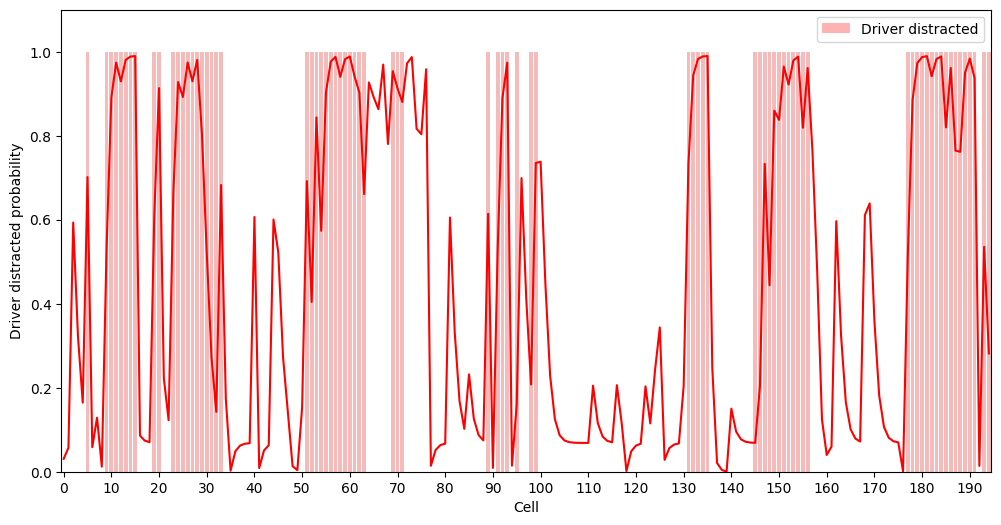

In [6]:
matplotlib.rc_file_defaults()
ax = sns.set_style(style=None, rc=None )

fig, ax = plt.subplots(figsize=(12,6))

plot_ = sns.lineplot(df_driver_state['cell'], df_driver_state['prob'], sort = False, color='r')
sns.barplot(data = df_driver_state, x='cell', y='true_state', color='r', alpha=0.3)

#ax.xaxis.set_major_locator(plt.MaxNLocator(3))

ax.set(xlabel='Cell', ylabel='Driver distracted probability')

new_ticks = [i.get_text() for i in plot_.get_xticklabels()]
plt.xticks(range(0, len(new_ticks), 10), new_ticks[::10])
plt.ylim(0,1.1)

legend_elements = [Patch(facecolor='r', alpha=0.3,
                         label='Driver distracted')]

ax.legend(handles=legend_elements)
plt.show()

#plot_.figure.savefig("figs/driver_state.png")

# Simulation aggregated results - Histograms

In [2]:
df = pd.read_csv("results/sim2.csv")
path = "figs/sim2/"

In [3]:
df.head()

,prop_manual,n_RtI,n_emergency,prop_rejected_RtI,avg_len_man,state_warnings,rock_warnings,puddle_warnings,crashes,skids,utility
0,0.137688,32,3,0.627907,6.850000,230,31,88,7,4,-0.354070
1,0.126633,28,0,0.600000,7.000000,235,20,85,3,2,0.065025
2,0.081407,16,0,0.636364,8.100000,250,11,49,0,2,0.365427
3,0.124623,35,2,0.520548,6.526316,257,12,81,1,2,0.262412
4,0.117588,31,1,0.515625,5.571429,274,12,66,2,3,0.157688


In [62]:
def plot_hist(df, x, xlab, path):
    
    matplotlib.rc_file_defaults()
    ax = sns.set_style(style=None, rc=None )
    fig, ax = plt.subplots(figsize=(12,6))
    plot_ = sns.distplot(df[x], bins=20, hist_kws={"rwidth":0.95,'edgecolor':'black', 'alpha':0.3},
                        norm_hist=False, kde=False)
    ax.set_xlabel(xlab, fontsize=20)
    ax.set_ylabel('Count', fontsize=20)
    ax.tick_params(labelsize=15)
    '''
    for bar in plot_.patches:
        h = bar.get_height()
        if h != 0:
            plot_.text(bar.get_x() + bar.get_width() / 2,
                      h,
                      f'{h:.0f}\n',
                      ha='center',
                      va='center')
    '''
    plot_.figure.savefig(path)

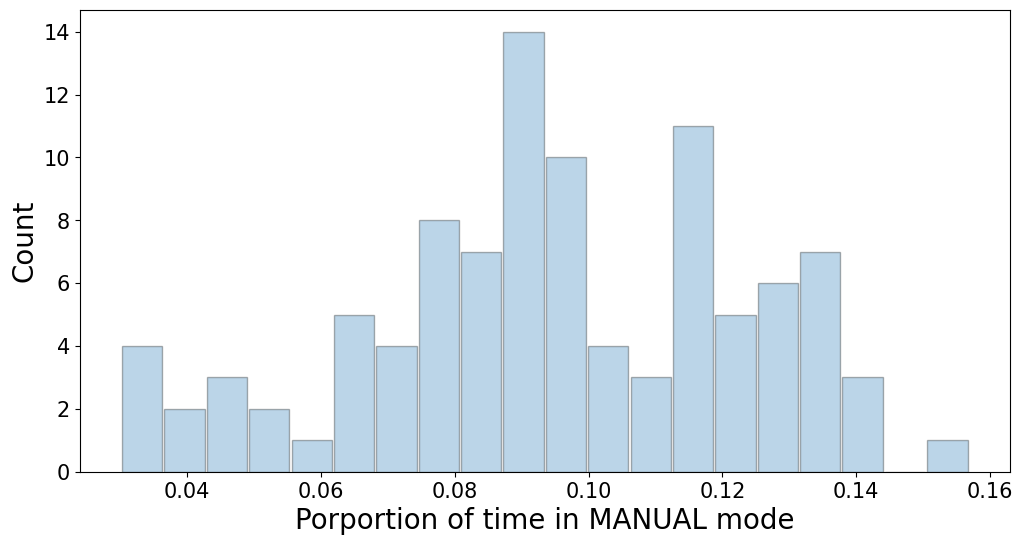

In [63]:
plot_hist(df, 'prop_manual', 'Porportion of time in MANUAL mode', path + 'prop_time_man_test.png')

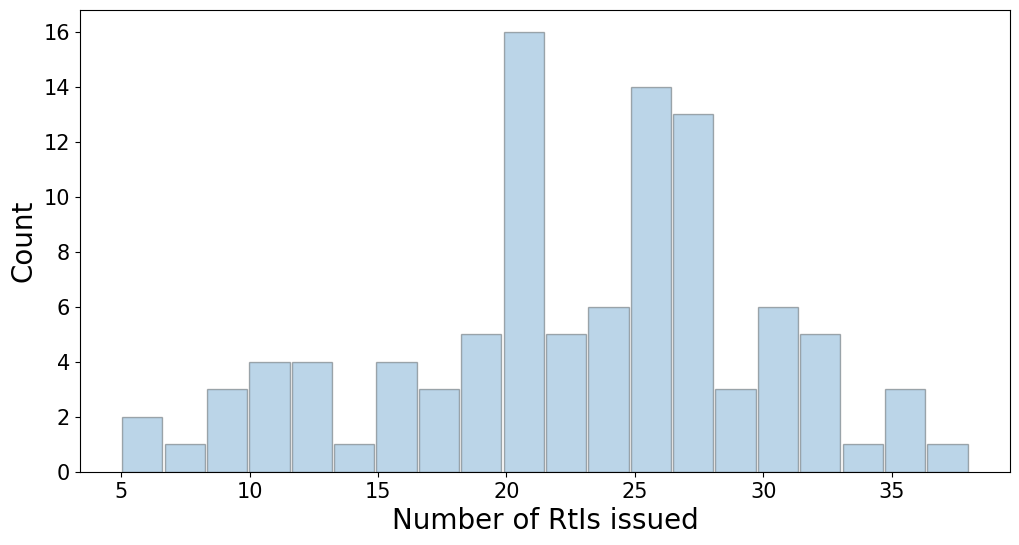

In [64]:
plot_hist(df, 'n_RtI', 'Number of RtIs issued', path + 'n_RtI_test.png')

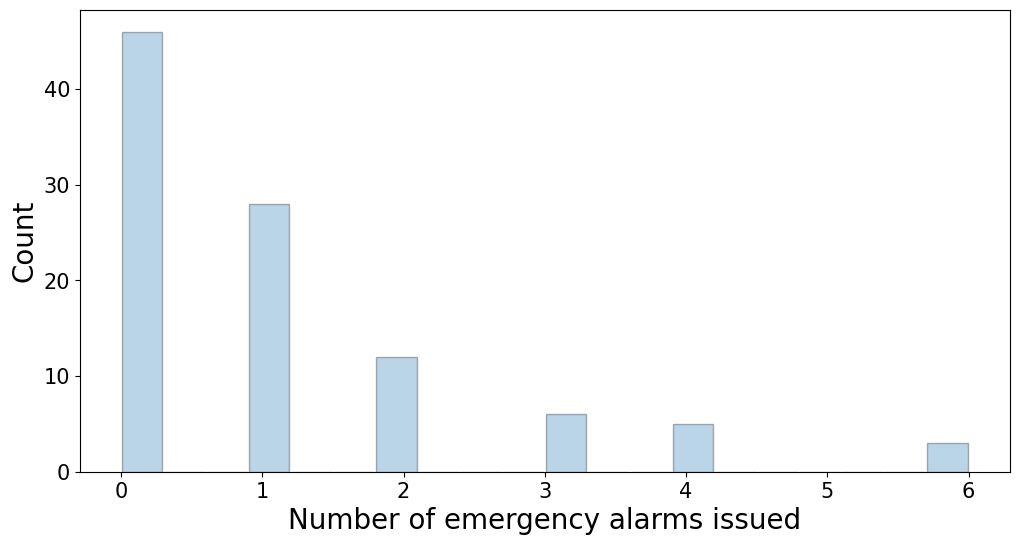

In [65]:
plot_hist(df, 'n_emergency', 'Number of emergency alarms issued', path + 'n_emergency_test.png')

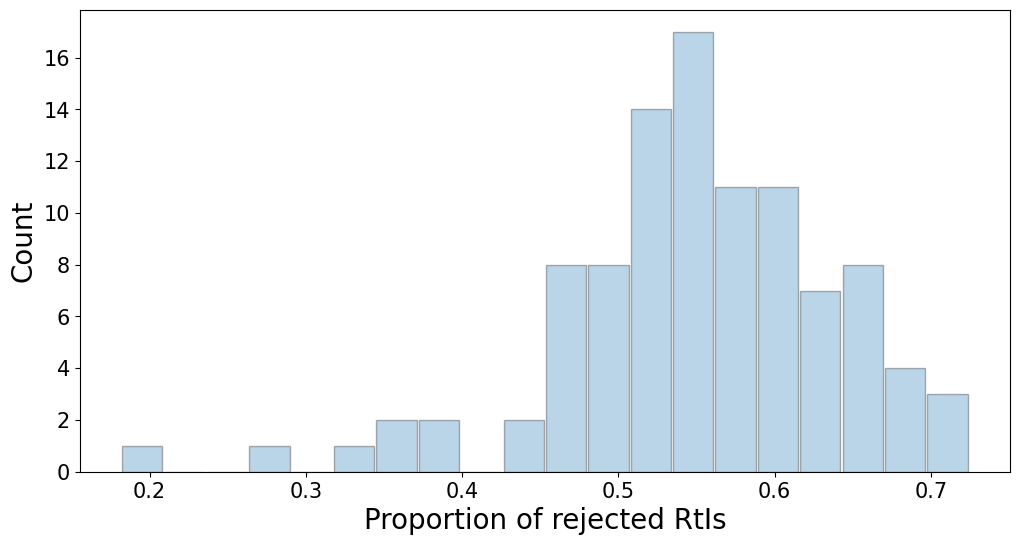

In [66]:
plot_hist(df, 'prop_rejected_RtI', 'Proportion of rejected RtIs', path + 'prop_rejected_RtI.png')

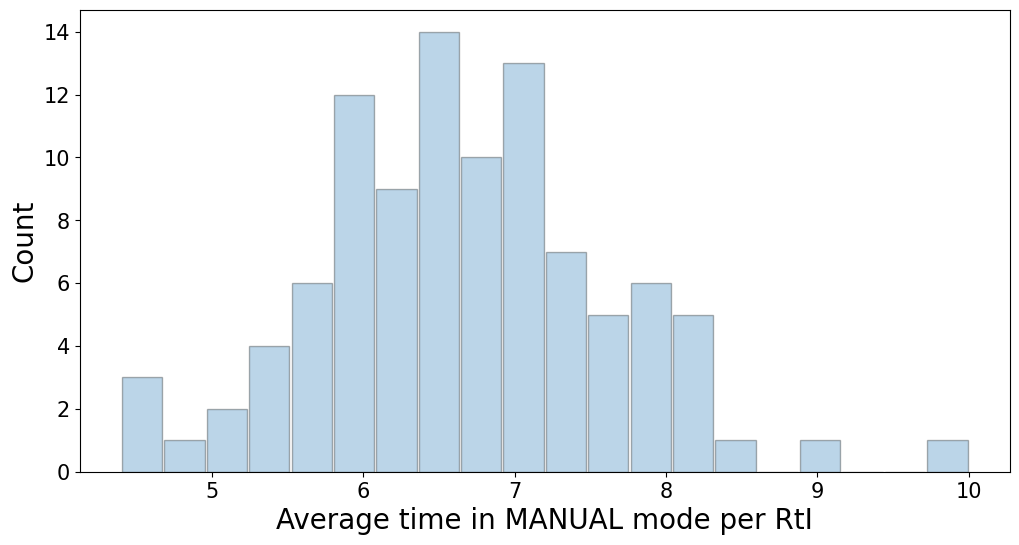

In [67]:
plot_hist(df, 'avg_len_man', 'Average time in MANUAL mode per RtI', path + 'avg_len_man_test.png')

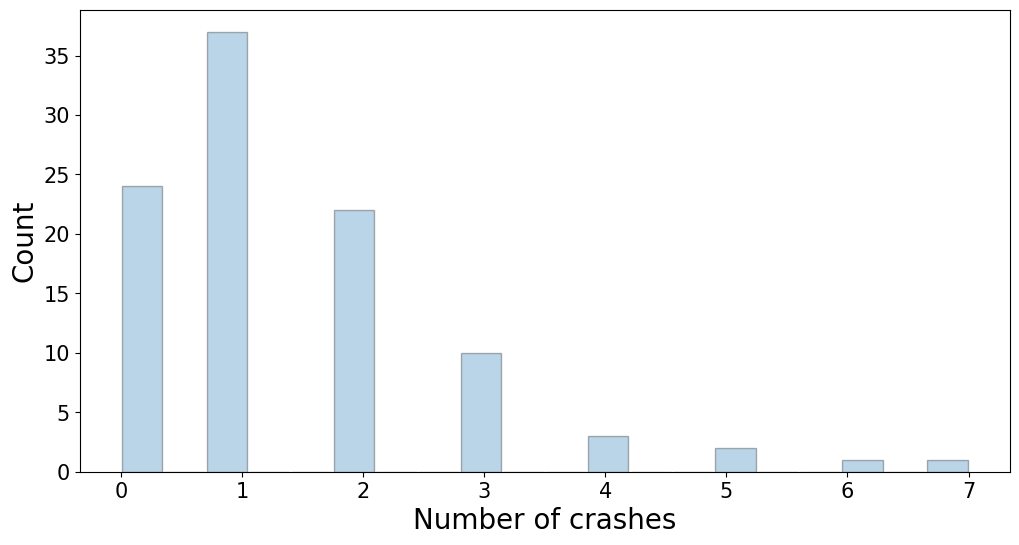

In [68]:
plot_hist(df, 'crashes', 'Number of crashes', path + 'crashes.png')

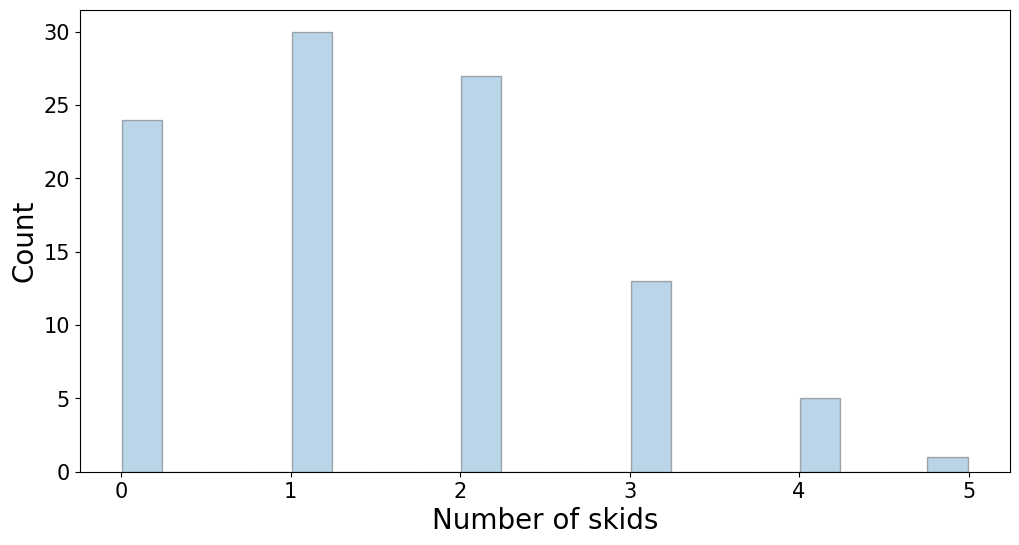

In [69]:
plot_hist(df, 'skids', 'Number of skids', path + 'skids.png')

# Simulation aggregated results - Boxplots

In [70]:
def plot_bp(df, y, ylab, path=None):
    
    matplotlib.rc_file_defaults()
    ax = sns.set_style(style=None, rc=None )
    fig, ax = plt.subplots(figsize=(10,10))
    plot_ = sns.boxplot(y=df[y])
    #sns.swarmplot(y=df[y], color=".25")
    ax.set_ylabel(ylab, fontsize=20)
    ax.tick_params(labelsize=15)
    if path is not None:
        plot_.figure.savefig(path)

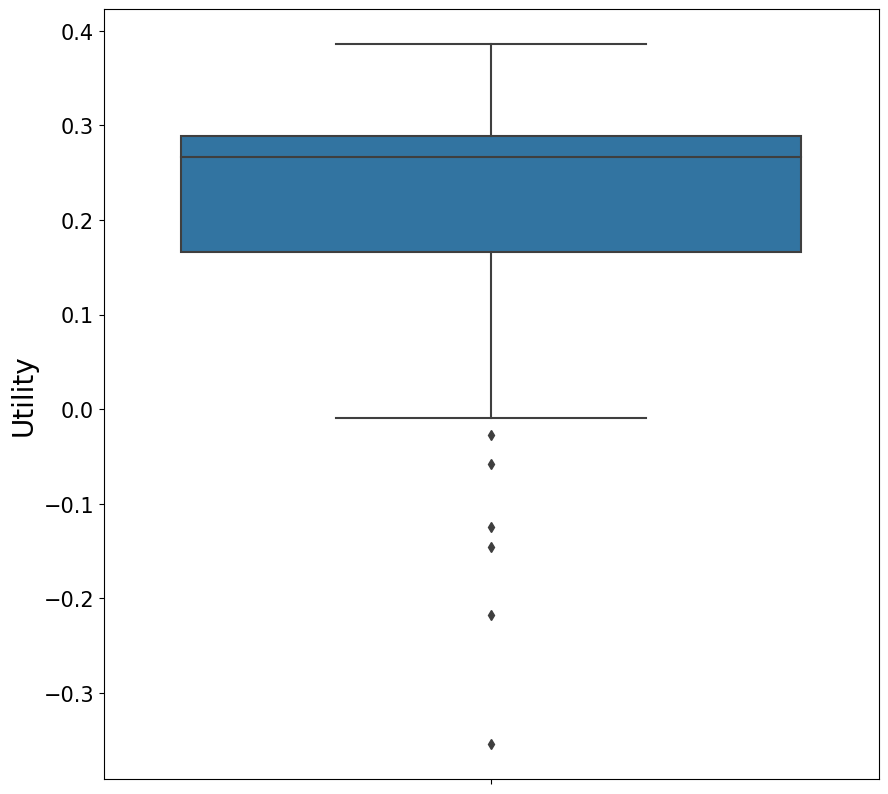

In [71]:
plot_bp(df, 'utility', 'Utility', path + 'utility_bp.png')

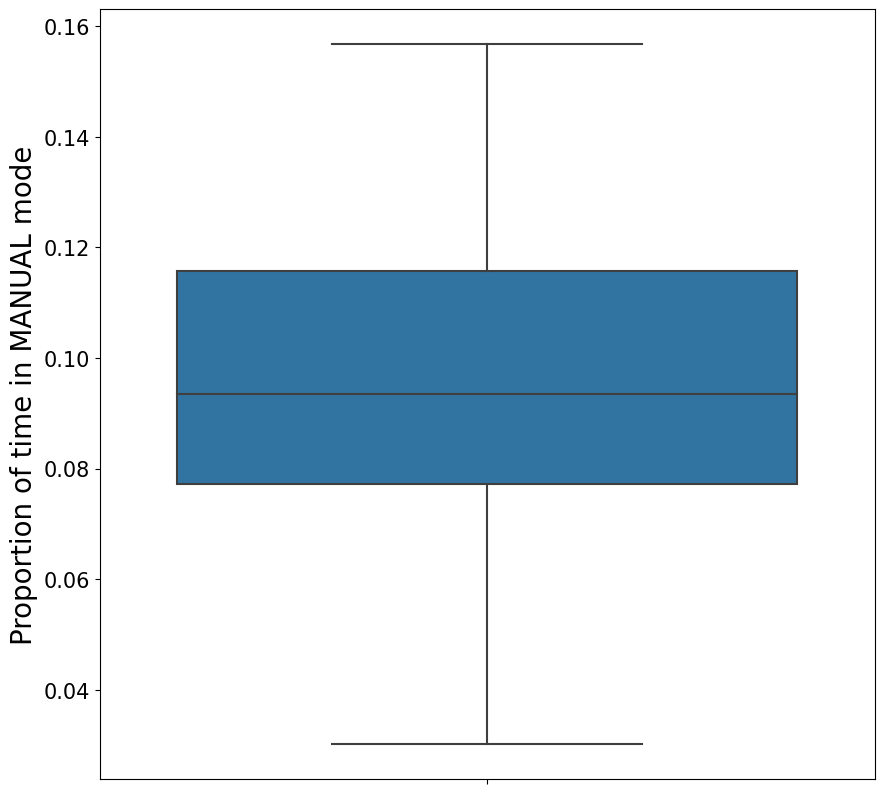

In [72]:
plot_bp(df, 'prop_manual', 'Proportion of time in MANUAL mode', path + 'prop_manual.png')

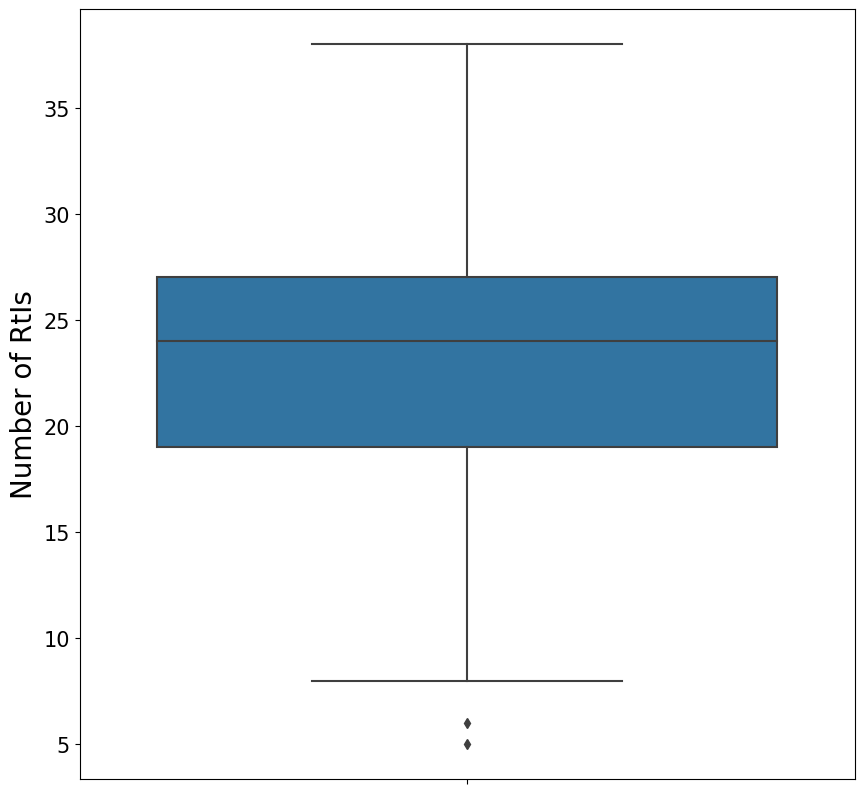

In [73]:
plot_bp(df, 'n_RtI', 'Number of RtIs', path + 'n_RtI.png')

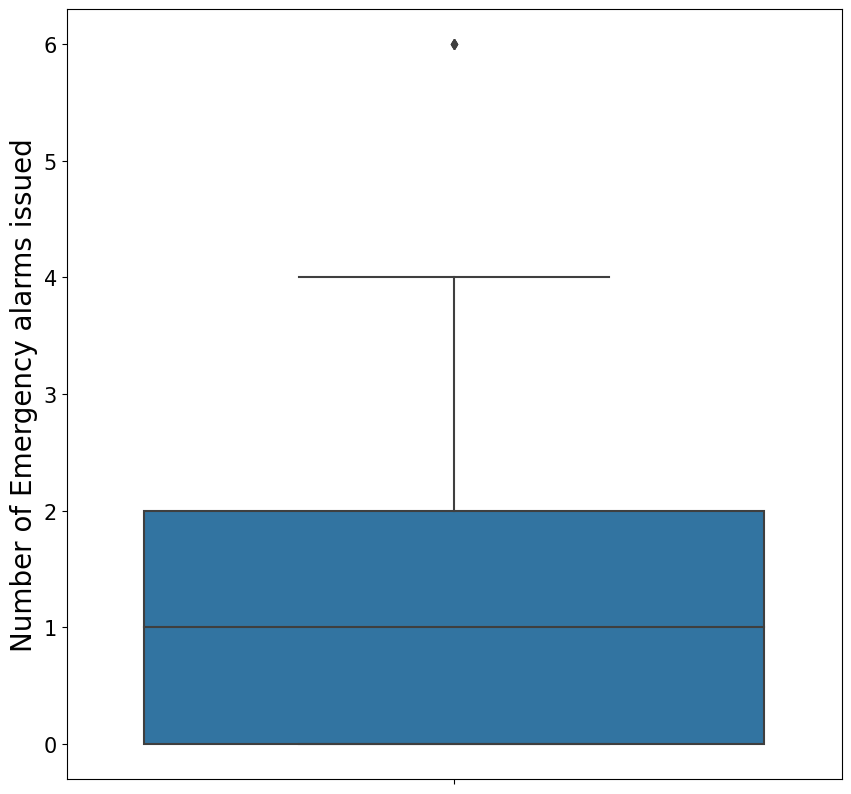

In [74]:
plot_bp(df, 'n_emergency', 'Number of Emergency alarms issued', path + 'n_emergency.png')